In [1]:
import os
import glob
import cv2
from matplotlib import pyplot as plt
import numpy as np
import face_recognition
import imutils

The face images of different persons are stored in the following directory.

In [2]:
DATASET = 'data/webapp'

We read the dataset and visualize some images. We discard the persons which have less than 50 face images to reduce noise and variance.

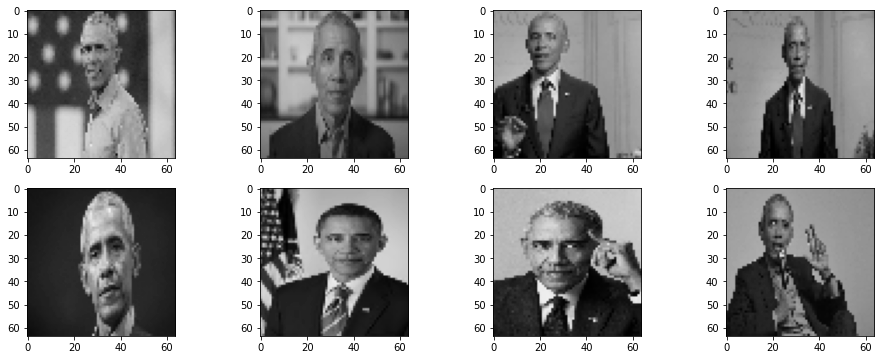

Read 27 images of 3 persons 


In [3]:
n_imgs = 27
width = height = 64

imgs = np.zeros((n_imgs, width, height, ), dtype=np.float32)
labels = np.zeros((n_imgs, ))
cnn_feats = np.zeros((n_imgs, 128))
fig = plt.figure(figsize=(16, 6))
i = 1
unique_labels = {}
c = 0
for root, dirs, files in os.walk(DATASET):
    for file in files:
        if file.endswith(".jpg") and len(os.listdir(root))>0:
            img_path = os.path.join(root, file)
            img_rgb = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
            img_rgb = imutils.resize(img_rgb, width=128)
            boxes = face_recognition.face_locations(img_rgb, model="cnn")
            encodings = face_recognition.face_encodings(img_rgb, boxes)
            if len(encodings)>0:
                cnn_feats[i-1]=encodings[0]
                
            img = cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2GRAY), (width, height))
            label = root.split('/')[-1]
            if label not in unique_labels:
                unique_labels[label] = c
                c+=1
            imgs[i-1] = np.array(img)
            labels[i-1] = unique_labels[label]
            if i<=8:
                plt.subplot(2, 4, i)
                plt.imshow(img, cmap='gray', vmin=0, vmax=255) 
            i+=1
plt.show()
print ("Read %s images of %s persons "%(i-1,c))

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, X_train_cnn, X_test_cnn, y_train, y_test = train_test_split(imgs, cnn_feats, labels, test_size=0.2, random_state=42)

X_train = X_train.reshape(-1,width*height)
X_test = X_test.reshape(-1,width*height)

## LDA and PCA Combination

In [5]:
from sklearn.decomposition import PCA
n_components = 8
print("Extracting the top {} eigenfaces from {} faces".format(n_components, X_train.shape[0]))
pca = PCA(n_components=n_components, whiten=True).fit(X_train)

# Transform data into principal components representation
print("Transforming the test data using the the orthonormal basis of PCA")
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

Extracting the top 8 eigenfaces from 21 faces
Transforming the test data using the the orthonormal basis of PCA


In [6]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
model = LinearDiscriminantAnalysis()
X_train_lda = model.fit_transform(np.concatenate((X_train, X_train_pca), axis=1), y_train)

In [7]:
# Evaluation of the model
y_pred = model.predict(np.concatenate((X_test, X_test_pca), axis=1))

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
print(classification_report(y_test, y_pred, ))

              precision    recall  f1-score   support

         0.0       1.00      0.75      0.86         4
         1.0       0.00      0.00      0.00         1
         2.0       0.50      1.00      0.67         1

    accuracy                           0.67         6
   macro avg       0.50      0.58      0.51         6
weighted avg       0.75      0.67      0.68         6



## LDA and PCA Combination with CNN featuers

In [9]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
model = LinearDiscriminantAnalysis()
X_train_lda = model.fit_transform(np.concatenate(( X_train_pca, X_train_cnn), axis=1), y_train)

In [10]:
# Evaluation of the model
y_pred = model.predict(np.concatenate((X_test_pca, X_test_cnn), axis=1))

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
print(classification_report(y_test, y_pred, ))

              precision    recall  f1-score   support

         0.0       1.00      0.75      0.86         4
         1.0       1.00      1.00      1.00         1
         2.0       0.50      1.00      0.67         1

    accuracy                           0.83         6
   macro avg       0.83      0.92      0.84         6
weighted avg       0.92      0.83      0.85         6

